In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [23]:
def getData(directory):
    #     end_time = 24 * 3600  # 24 hours
    for sdir_path, sdir in [
        (sdir.path, sdir.name)
        for sdir in sorted(os.scandir(directory), key=lambda x: int(x.name.split("_")[-1]))
        if sdir.is_dir()
    ]:
        print(sdir)
        for root, subdirs, files in os.walk(sdir_path):
            for file in files:
                dirs = root.split("/")
                if file == "0.trips.csv.gz" and "car" in dirs:
                    dists_car = pd.read_csv(os.path.join(root, file), sep=";")[
                        "traveled_distance"
                    ]
                if file == "0.vehicleDistanceStats_drt.csv" and "bimodal" in dirs:
                    dists_bim = pd.read_csv(os.path.join(root, file), sep=";")[
                        "drivenDistance_m"
                    ]
                if file == "trip_success.csv.gz":
                    rejections = pd.read_csv(
                        os.path.join(root, file), sep=";"
                    )
                if file == "0.CummulativePtDistance.txt":
                    dist_train = pd.read_csv(os.path.join(root,file)).values[0,0]

        yield int(sdir.split("_")[-1]), dists_car, dists_bim, dist_train, rejections

In [27]:
path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/varyingllprime_periodicTransit4"

l_lps = np.empty(9)
carbon_indexs = np.empty(9)

for i,(l_lp, dists_car, dists_bim, dist_train, rejections) in enumerate(getData(path)):
    l_lps[i] = l_lp
    print("Rejections: ", len(rejections[~rejections["tripSuccess"]])/len(rejections))
    dists_car_for_rejected = dists_car.loc[rejections[~rejections["tripSuccess"]]["personId"].to_numpy()]
    carbon_index = (dists_bim.sum()+dists_car_for_rejected.sum()+dist_train)/dists_car.sum()
    carbon_indexs[i] = carbon_index
    print(l_lp)
    print(carbon_index)
    print("-----")

l_lp_2
Rejections:  0.35422
2
0.6671637352114224
-----
l_lp_3
Rejections:  0.33348
3
0.6793408304885846
-----
l_lp_4
Rejections:  0.28252
4
0.6447593186627943
-----
l_lp_5
Rejections:  0.27015
5
0.6362387009340538
-----
l_lp_6
Rejections:  0.30942
6
0.6726035625875942
-----
l_lp_7
Rejections:  0.26806
7
0.6348885355786582
-----
l_lp_8
Rejections:  0.26332
8
0.6304820745187933
-----
l_lp_9
Rejections:  0.21159
9
0.582345351253719
-----
l_lp_10
Rejections:  0.23556
10
0.6012114192980529
-----


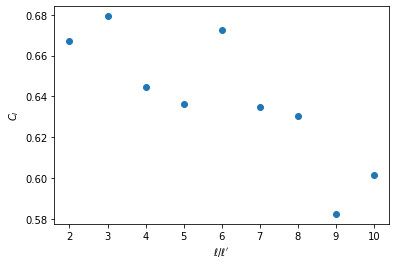

In [28]:
fig, ax = plt.subplots()

ax.scatter(l_lps, carbon_indexs)
ax.set_ylabel(r"$C_I$")
ax.set_xlabel(r"$\ell/\ell^\prime$")

# fig.savefig("CarbonIdxVaryingllprime.png", dpi=200)
plt.show()

In [58]:
path = "/home/helge/Applications/matsim/matsim-bimodal/scenarios/fine_grid/bimodal/output/l_lp_10/bimodal/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/varyingllprime/l_lp_10/bimodal/"


rejections = pd.read_csv(
    os.path.join(path, "trip_success.csv.gz"), sep=";"#, header=None
)

0.0412
0.38571428571428573


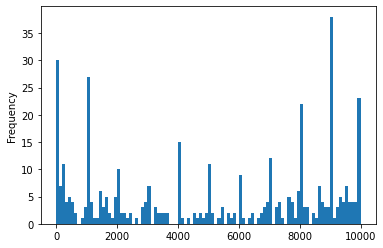

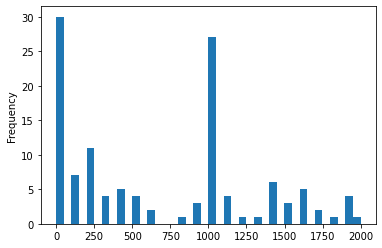

In [59]:
print(len(rejections[~rejections["tripSuccess"]])/len(rejections))

rejections[~rejections["tripSuccess"]]["lastCoordX"].plot(kind="hist", bins=100)

plt.figure()
rejections[(~rejections["tripSuccess"]) & (rejections["lastCoordX"]<2000)]["lastCoordX"].plot(kind="hist", bins=40)

xvalue = 0
print(len(rejections[(~rejections["tripSuccess"]) & (rejections["lastCoordX"]==xvalue)])/len(rejections[rejections["lastCoordX"]==xvalue]))

plt.show()